# CSCI 113i Final Project
Cheng, Montemayor, Shu Too - CSCI 113i J

## Machine Learning
We first import the pertinent libraries and our dataset.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Balancing
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Machine learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [ ]:
df = pd.read_csv('e-shop_processed.csv', index_col = 0)

# Extra copy
copy = df.copy()

df

,main_category,location,model,price,page,weekday,region,colour_type
19,2,6,2,38,1,1,4,1
20,3,2,1,48,1,1,4,2
21,3,3,1,48,1,1,4,4
22,3,4,2,28,1,1,4,5
23,3,6,1,48,1,1,4,1
...,...,...,...,...,...,...,...,...
165221,3,1,2,33,4,1,1,4
165470,1,4,1,62,1,1,1,3
165471,1,1,1,43,1,1,1,3
165472,3,1,1,43,1,1,1,3


### Balancing the Dataset
Before we begin our machine learning, we note that part of our business objective is concerned with the placement of products on the online shopping website, but our data for this feature is imbalanced. This can result in data skewed towards the majority categories under particular features.

Hence, we aim to use `RandomUnderSampler` to undersample the majority category in `location` (i.e., the feature that stores where the product was placed on the screen when it was purchased) to balance the dataset.

In [ ]:
df['location'].value_counts()

1    5783
2    5476
4    4507
5    4480
3    3630
6    3474
Name: location, dtype: int64

Class=0, n=3474 (16.667%)
Class=1, n=3474 (16.667%)
Class=2, n=3474 (16.667%)
Class=3, n=3474 (16.667%)
Class=4, n=3474 (16.667%)
Class=5, n=3474 (16.667%)


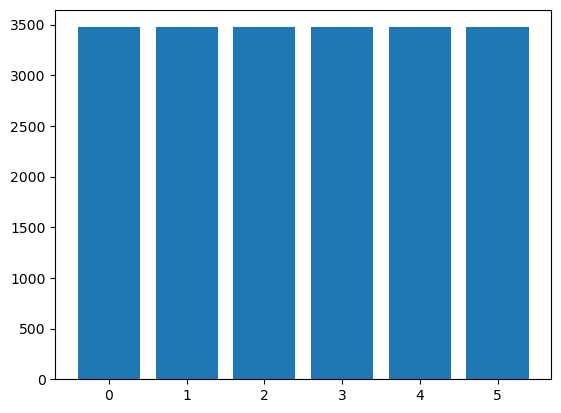

In [ ]:
# We set the feature that we plan to implement the balancing on as the last element.
def end_element(df, column_name):
    if column_name in df.columns:
        cols = list(df.columns)
        cols.append(cols.pop(cols.index(column_name)))
        df = df[cols]
    else:
        print(f"The column '{column_name}' is not in the DataFrame.")
    return df

df = end_element(df, 'location')
data = df.values

# Splitting into input and output elements
X, y = data[:, :-1], data[:, -1]
# Label encoding
y = LabelEncoder().fit_transform(y)
# Defining the pipeline and transforming the dataset
under = RandomUnderSampler()
X, y = under.fit_resample(X, y)

# Summary of Redistribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

We now set this balanced dataset as our new DataFrame. Note that the categories have been revised (i.e., written as 0-5 instead of 1-6), so we will revert it to its original labels as well.

In [ ]:
# Setting the new data as a DataFrame
df1 = pd.concat([pd.DataFrame(X, columns = df.columns[:-1]), pd.DataFrame(y, columns = [df.columns[-1]])], axis = 1)

# Reverting to the original encoding
df1[df.columns[-1]] = df1[df.columns[-1]] + 1

df1

,main_category,model,price,page,weekday,region,colour_type,location
0,1,1,43,1,0,1,3,1
1,2,1,57,1,0,1,2,1
2,1,1,28,1,1,1,4,1
3,2,1,52,1,1,1,3,1
4,1,1,62,3,1,1,1,1
...,...,...,...,...,...,...,...,...
20839,1,2,33,2,1,1,1,6
20840,3,1,38,3,1,1,1,6
20841,3,1,57,3,1,1,1,6
20842,4,1,33,1,1,1,3,6


We now conduct standard pre-processing procedures before machine learning, such as scaling and one-hot encoding.

In [ ]:
# Z-score scaling on price
df1['price'] = (df1['price'] - df1['price'].mean())/df1['price'].std()

# One-hot encoding for region, color, location
region_dummies = pd.get_dummies(df1['region'], prefix = 'region')
color_dummies = pd.get_dummies(df1['colour_type'], prefix = 'color')
location_dummies = pd.get_dummies(df1['location'], prefix = 'location')
df1 = pd.concat([df1, region_dummies, color_dummies, location_dummies], axis = 1)

# Dropping the original columns
df1 = df1.drop(columns = ['region', 'colour_type', 'location'])

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20844 entries, 0 to 20843
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   main_category  20844 non-null  int64  
 1   model          20844 non-null  int64  
 2   price          20844 non-null  float64
 3   page           20844 non-null  int64  
 4   weekday        20844 non-null  int64  
 5   region_1       20844 non-null  uint8  
 6   region_2       20844 non-null  uint8  
 7   region_3       20844 non-null  uint8  
 8   region_4       20844 non-null  uint8  
 9   region_5       20844 non-null  uint8  
 10  color_1        20844 non-null  uint8  
 11  color_2        20844 non-null  uint8  
 12  color_3        20844 non-null  uint8  
 13  color_4        20844 non-null  uint8  
 14  color_5        20844 non-null  uint8  
 15  location_1     20844 non-null  uint8  
 16  location_2     20844 non-null  uint8  
 17  location_3     20844 non-null  uint8  
 18  locati

## K-Means Clustering

### Calculating Ideal Number of Clusters
We will use the elbow plot and silhouette score to identify the ideal number of clusters.

For the elbow plot, we want to find the number of clusters $n$ when the graph "bends".

On the other hand, we want to take the number of clusters $n$ whose silhouette score is closest to 1.

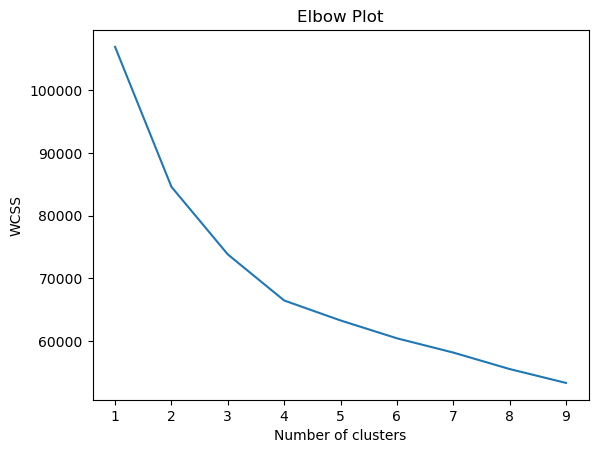

In [ ]:
# Elbow plot to calculate ideal number of clusters

# Within-cluster sum of squares
wcss = []

# Check the number of clusters.
for n_clusters in range(1, 10):

    # Instantiate the model with `n_clusters` clusters.
    kmeans = KMeans(n_clusters)

    # Fit the model.
    kmeans.fit(df1)

    # `kmeans.inertia_`: WCSS
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

# Plot `n_clusters` vs. WCSS.
plt.plot(range(1,10), wcss)
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

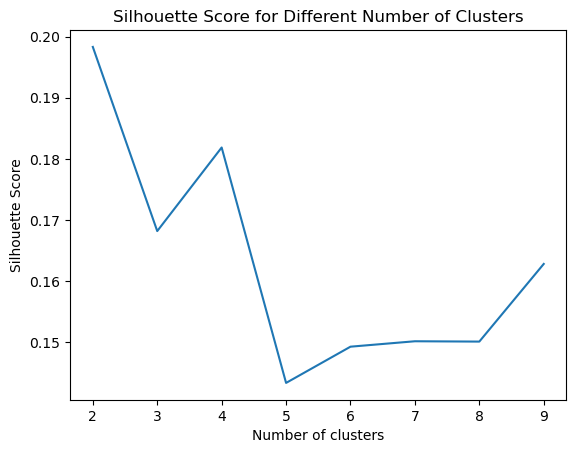

In [ ]:
# Silhouette score to calculate ideal number of clusters

# Initialize a list containing the silhouette scores
ss_group = []

# Iterate over 2 up to 9 clusters.
# Note that silhouette score doesn't work for 1 cluster.
for n_clusters in range(2, 10):

    # Instantiate the model
    kmeans = KMeans(n_clusters)

    # Predicted labels
    labels = kmeans.fit_predict(df1)

    # Take the silhouette score for a particular number of clusters
    # and append it to the list containing the silhouette scores

    ss_group.append(silhouette_score(df1, labels, metric='euclidean'))

# Plot `n_clusters` vs. silhouette score.
plt.plot(range(2, 10), ss_group)
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

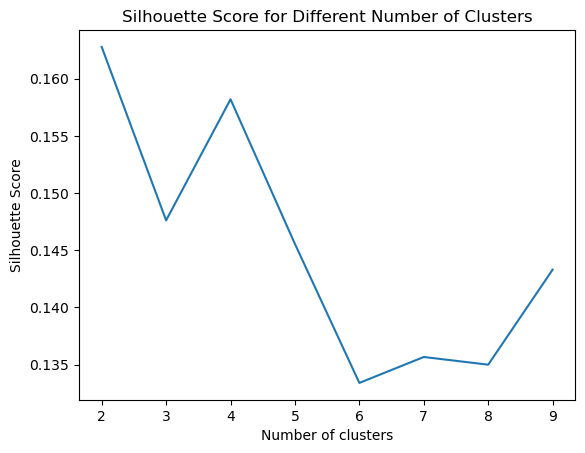

In [ ]:
# Silhouette score to calculate ideal number of clusters

# Initialize a list containing the silhouette scores
ss_group = []

# Iterate over 2 up to 9 clusters.
# Note that silhouette score doesn't work for 1 cluster.
for n_clusters in range(2, 10):

    # Instantiate the model
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

    # Predicted labels
    labels = hierarchical_cluster.fit_predict(df1)

    # Take the silhouette score for a particular number of clusters
    # and append it to the list containing the silhouette scores

    ss_group.append(silhouette_score(df1, labels, metric='euclidean'))

# Plot `n_clusters` vs. silhouette score.
plt.plot(range(2, 10), ss_group)
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Using the Appropriate Number of Clusters
We decide to cluster the dataset into four.

In [ ]:
# Instantiate a model with 4 clusters.
kmeans = KMeans(n_clusters=4)

# Fit the model.
kmeans.fit(df1)

# Save the centroids of the clusters and the labels of each row.
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a copy of the DataFrame and add the labels as a column.
df_kmeans = df1.copy()
df_kmeans['cluster'] = labels
df_kmeans

,main_category,model,price,page,weekday,region_1,region_2,region_3,region_4,region_5,...,color_3,color_4,color_5,location_1,location_2,location_3,location_4,location_5,location_6,cluster
0,1,1,-0.186368,1,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,2,1,0.875448,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
2,1,1,-1.324028,1,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,2,1,0.496228,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,2
4,1,1,1.254668,3,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20839,1,2,-0.944808,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20840,3,1,-0.565588,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
20841,3,1,0.875448,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
20842,4,1,-0.944808,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [ ]:
df_kmeans['cluster'].value_counts()

0    7125
2    6060
1    4941
3    2718
Name: cluster, dtype: int64

## Hierarchical Clustering

In [ ]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(df1)
df_hc = df1.copy()
df_hc['cluster'] = labels
df_hc

,main_category,model,price,page,weekday,region_1,region_2,region_3,region_4,region_5,...,color_3,color_4,color_5,location_1,location_2,location_3,location_4,location_5,location_6,cluster
0,1,1,-0.186368,1,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,2,1,0.875448,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
2,1,1,-1.324028,1,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,2,1,0.496228,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,2
4,1,1,1.254668,3,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20839,1,2,-0.944808,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
20840,3,1,-0.565588,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
20841,3,1,0.875448,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
20842,4,1,-0.944808,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
df_hc['cluster'].value_counts()

1    6141
0    5897
2    5102
3    3704
Name: cluster, dtype: int64

## Results

In [ ]:
def results(df, clustering_method):

    # Part 1: Page
    df_label_page = pd.crosstab(df['cluster'], df['page']) # absolute
    df_label_page_normalized = df_label_page.T / df_label_page.sum(axis = 1) # relative, wrt label
    sns.heatmap(df_label_page_normalized, annot = True) # heatmap
    plt.title(f'Heatmap for Page vs. Label ({clustering_method})')
    plt.show()

    # Part 2: Main Category
    df_label_maincat = pd.crosstab(df['cluster'], df['main_category']) # absolute
    df_label_maincat_normalized = df_label_maincat.T / df_label_maincat.sum(axis = 1) # relative, wrt label
    sns.heatmap(df_label_maincat_normalized, annot = True) # heatmap
    plt.title(f'Heatmap for Main Category vs. Label ({clustering_method})')
    plt.show()

    # Part 3: Price
    sns.boxplot(x = 'cluster', y = 'price', data = df) # boxplot
    plt.title(f'Heatmap for Price vs. Label ({clustering_method})')
    plt.show()

    # Part 4: Region
    region_cols = ['region_' + str(i) for i in range(1, 6)]
    df_label_region = pd.crosstab(df['cluster'], [df[col] for col in region_cols]) # absolute
    df_label_region.columns = region_cols[::-1] # switch column order
    df_label_region = df_label_region.iloc[:, ::-1]
    df_label_region_normalized = df_label_region / df_label_region.sum(axis = 0) # relative, wrt region
    sns.heatmap(df_label_region_normalized, annot = True) # heatmap
    plt.title(f'Heatmap for Region vs. Label ({clustering_method})')
    plt.show()

    # Part 5: Location
    location_cols = ['location_' + str(i) for i in range(1, 7)]
    df_label_location = pd.crosstab(df['cluster'], [df[col] for col in location_cols]) # absolute
    df_label_location.columns = location_cols[::-1] # switch column order
    df_label_location = df_label_location.iloc[:, ::-1]
    df_label_location_normalized = df_label_location.T / df_label_location.sum(axis = 1) # relative, wrt label
    sns.heatmap(df_label_location_normalized, annot = True)
    plt.title(f'Heatmap for Location vs. Label ({clustering_method})')
    plt.show()

    # Part 6: Color
    color_cols = ['color_' + str(i) for i in range(1, 6)]
    df_label_color = pd.crosstab(df['cluster'], [df[col] for col in color_cols]) # absolute
    df_label_color.columns = color_cols[::-1] # switch column order
    df_label_color = df_label_color.iloc[:, ::-1]
    df_label_color_normalized = df_label_color.T / df_label_color.sum(axis = 1) # relative, wrt label
    sns.heatmap(df_label_color_normalized, annot = True) # heatmap
    plt.title(f'Heatmap for Color vs. Label ({clustering_method})')
    plt.show()

    # Part 7: Weekday
    df_label_weekday = pd.crosstab(df['cluster'], df['weekday']) # absolute
    df_label_weekday_normalized = df_label_weekday.T / df_label_weekday.sum(axis = 1) # relative, wrt label
    sns.heatmap(df_label_weekday_normalized, annot = True) # heatmap
    plt.title(f'Heatmap for Weekday vs. Label ({clustering_method})')
    plt.show()

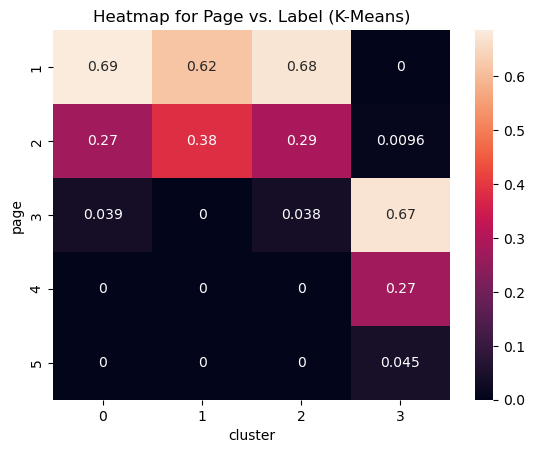

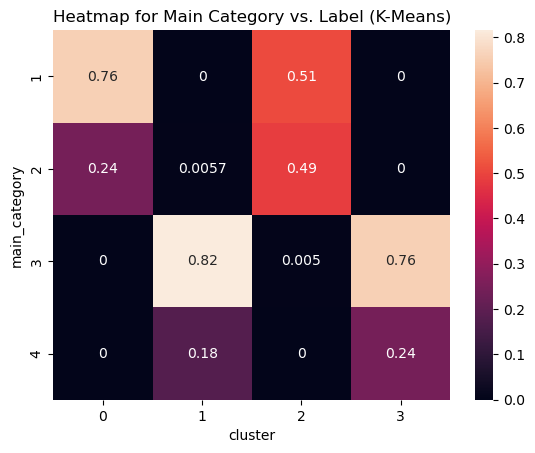

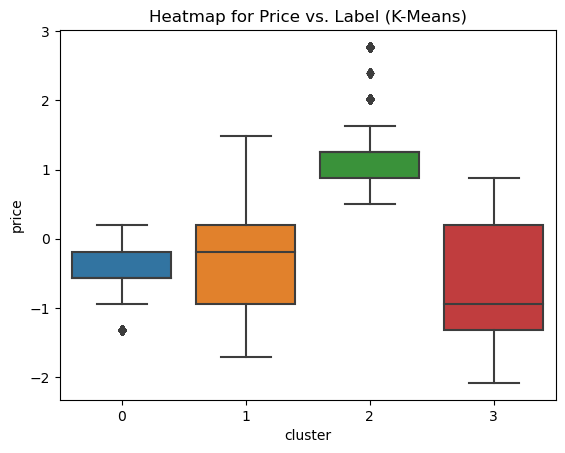

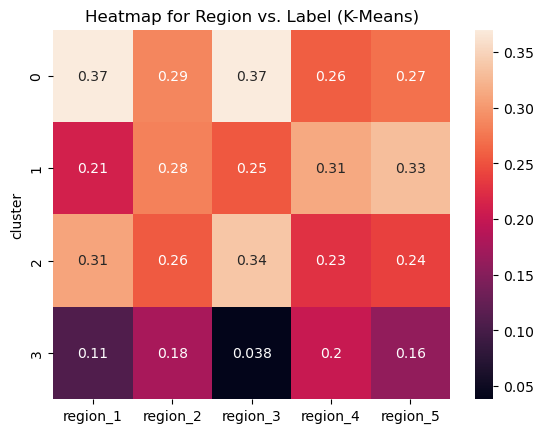

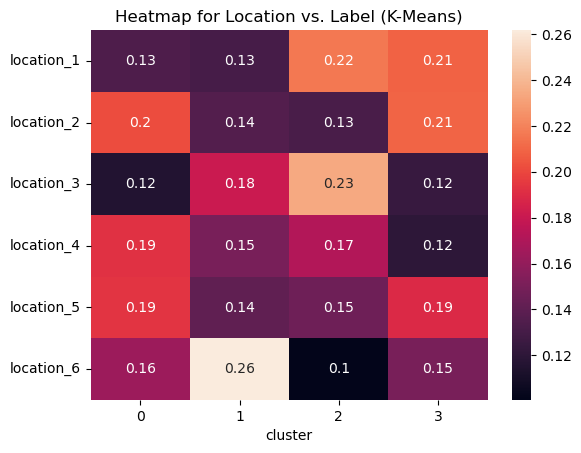

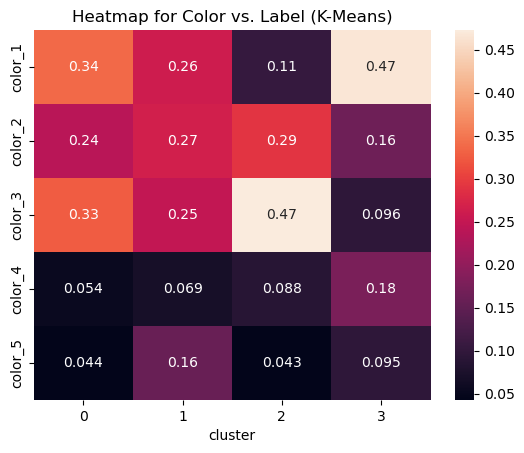

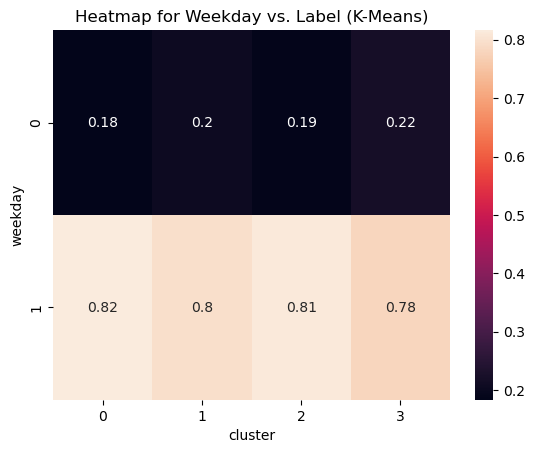

In [ ]:
results(df_kmeans, 'K-Means')

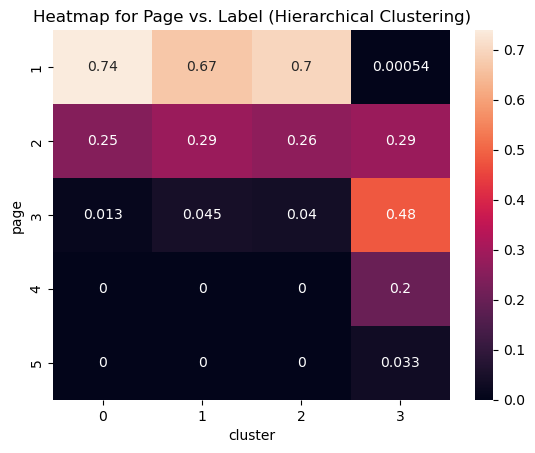

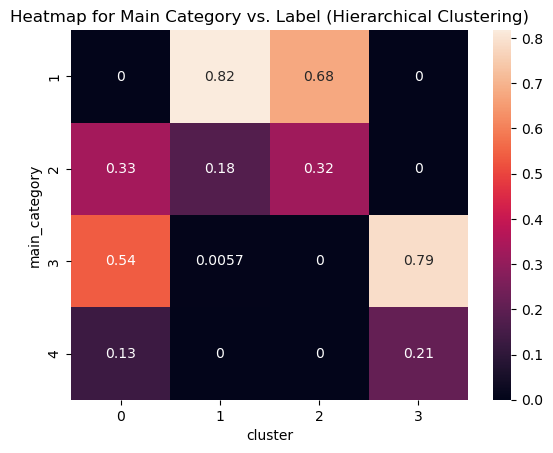

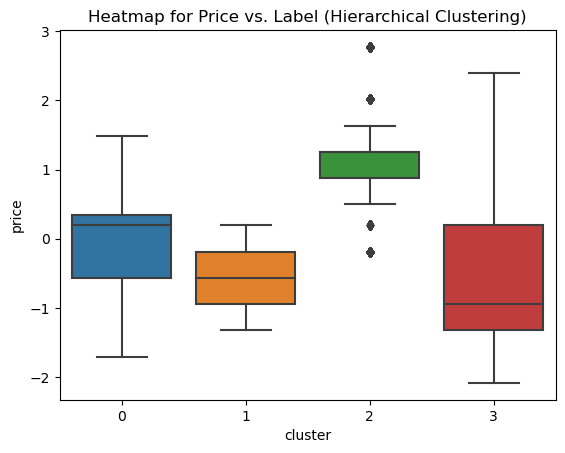

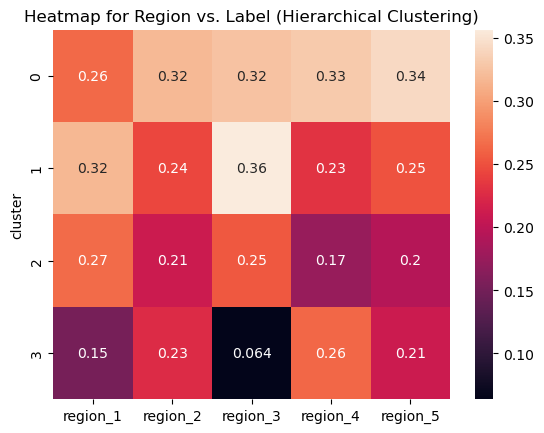

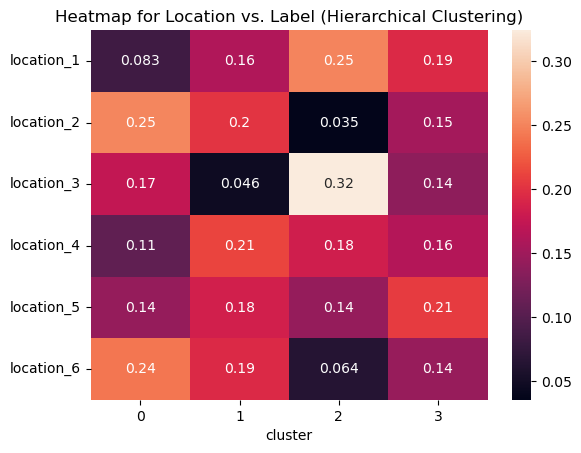

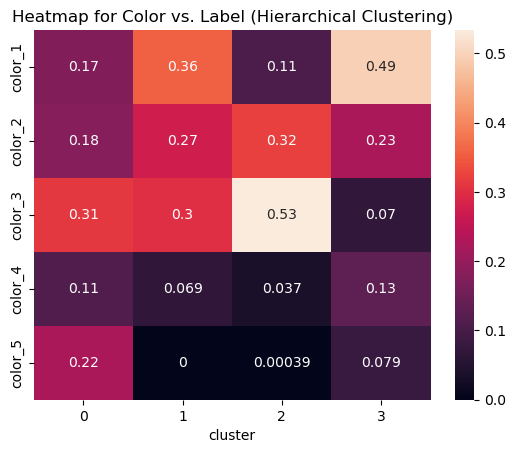

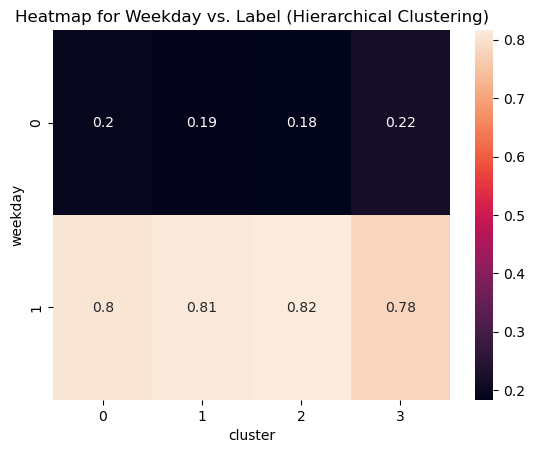

In [ ]:
results(df_hc, 'Hierarchical Clustering')